# NLTK 


NLTK or Natural Language Toolkit is the *de-facto* standard python module for building and running natural language processing applications in the language.

It consists of a collection of widely used datasets and algorithms for language processing applications such as tokenizers, part-of-speech taggers, stopword sets, standard text sets and trainable machine-learning algorithms.

Using the toolkit requires a reasonable working knowledge of Python which hopefully by studying the [preceeding exercises](https://brainsteam.co.uk/wiki/public:phd:teaching:cs918) you will have by now.

In this exercise we will use a number of the skills we have already examined to do some analysis on the [ART corpus](https://www.aber.ac.uk/en/cs/research/cb/projects/art/art-corpus/).

## About the dataset

If you have been through the XML exercise then you will already have been briefly introduced to the corpus. It consists of 225 biochemistry papers that have been broken up into individual sentences.

Each sentence has also been annotated with a label that describes the core scientific concept (CoreSC) that the sentence encapsulates.

For example, a sentence might be labelled "Motivation" if it explains why the author is carrying out a particular study or it might be labelled "Hypothesis" if it discusses expected results of a study. You can find out more about the annotation scheme specification [in this paper by Liakata et al. 2010](http://www.lrec-conf.org/proceedings/lrec2010/pdf/644_Paper.pdf).

## What can we find out?

Let's play with the data! We know that a particular sentence has a particular label. From this, can we make any assumptions about the words in the sentences? Are there some words that occur more frequently in some types of sentences?

Let's find out...

## Preparing the data

The first thing we need to do is extract a list of sentences and their respective CoreSC label. I have downloaded the ART corpus `tar.gz` file and placed it in the assets folder in this project. The following code iterates over the contained folders, finding all XML files and parsing them.

First we import requisite libraries...

In [2]:
import nltk
import os #we haven't used this one before. Check out the docs https://docs.python.org/3/library/os.html

import xml.etree.ElementTree as ET

We define a function for parsing the paper, extracting sentences and returning a list of tuples (sentence text,label)


In [3]:
def extract_paper(filename):
    
    #open and parse the paper
    tree = ET.parse("assets/b414459g_mode2.xml")
    root = tree.getroot()
    
    sents = []
    
    #iterate through sentences
    for sent in root.iter("s"):
        annoArt = sent.find('annotationART')
        id = sent.get("sid")
        text = "".join(annoArt.itertext())
        coreSC = annoArt.get("type")
        sents.append( (filename, id, text,coreSC) )
    
    return sents


We iterate through all papers in the ART corpus using [`os.walk`](https://docs.python.org/3/library/os.html#os.walk) which recursively steps through all files and subdirectories in a given directory, allowing you to process any file of interest.

In [6]:
art_path = "assets/ART_Corpus"

all_sents = []

filecount = 0

# this layer of the for loop iterates through each subdirectory of the given path
# producing a list of directories and files in that immediate directory.
# root represents the (sub)directory currently being inspected
for root, dirs, files in os.walk(art_path):
    
    #we loop through the list of files in the current subdirectory
    for file in files:
        
        if file.endswith(".xml"):
            filecount += 1
            #we use os.path.join to concatenate the directory name and file name safely
            #with respect to slashes in the path
            fullpath = os.path.join(root,file)
            
            #we parse the file and keep the sentences
            all_sents += extract_paper(file)
            
#lets get a total count of sentences collected and files examined
print("Inspected {} files".format(filecount))
print ("Collected {} sentences".format(len(all_sents)))

Inspected 225 files
Collected 16650 sentences


As a sanity check, let's inspect 5 sentences in the array and make sure that they are of the format (filename, id, some text, coresc). We use the standard library module [`random`](https://docs.python.org/3.0/library/random.html) to pick 5 from the list at random. 

In [7]:
import random

randsents = random.sample(all_sents,5)

for senttuple in randsents:
    print (senttuple)

('b407082h_mode2.xml', '2', 'Optical tweezers are used to control aerosol droplets, 4–14 μm in diameter, over time frames of hours at trapping powers of less than 10 mW.', 'Res')
('b312040f_mode2.xml', '71', 'The results from the coagulation measurement shown in Fig. 5 illustrate that the additive volumes of the two individual droplets and the volume of the coagulated droplet are in agreement to within ±3 × 10−19 m3.', 'Obs')
('b312040f_mode2.xml', '14', 'The scattering force acts in the direction of propagation of the laser and is proportional to the light intensity, ultimately acting to displace the particle from the beam focus.', 'Bac')
('b414641g_mode2.xml', '15', 'Conversely, the gradient force acts to draw the dielectric sphere towards the beam focus and is proportional to the gradient of the light intensity.', 'Bac')
('b313399k_mode2.xml', '45', 'The fingerprint of resonant wavelengths can be used to determine the droplet size with nanometre precision.4,5', 'Bac')


This looks right. Out of curiosity, lets see how many of each CoreSC type there are and plot a Pie chart using matplotlib.


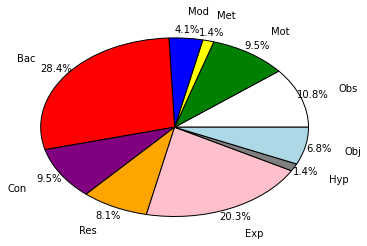

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

#read about the counter object on the 
#collections doc page (https://docs.python.org/3/library/collections.html#collections.Counter)
from collections import Counter 

lbl_tally = Counter([ lbl for file, id, text, lbl in all_sents])

total = len(all_sents)

percentages = { x: (lbl_tally[x] / total * 100) for x in lbl_tally }

labels = [ x for x in percentages.keys() ]
values = [ percentages[x] for x in labels]

plt.pie(values, 
        labels=labels, 
        labeldistance=1.3,
        autopct="%1.1f%%", 
        pctdistance=1.1,
        colors=["white","green","yellow","blue","red", "purple", "orange","pink","grey","lightblue"])
plt.show()

So we see that there is quite a lot of variation in the types of sentences and their respective representation within the corpus. Background takes up over a quarter of the total number of sentences and hypothesis a measly 1.4%.

We need to remember this in our experiments - all CoreSCs are not born equal - some are more likely to occur than others.

## Word distributions

Let's look at which words are most likely to occur in different sentence types. We build a dictionary of words by parsing and tokenizing every single sentence in our collection. We store a record of each word's occurence in each CoreSC so that we can build a frequency distribution table later. We will depend upon NLTK heavily for this work.

### Tokenizing sentences
First we use `nltk.word_tokenize` to break down each sentence into a series of "words" and build a dictionary. Then we examine the top 10 words.

In [10]:
dictionary = Counter()

for file, id, text, lbl in all_sents:
    
    words = nltk.word_tokenize(text)
    dictionary.update(words)
    
print(dictionary.most_common(10))

[('the', 33975), ('of', 23850), (',', 18000), ('.', 13275), ('a', 12375), ('and', 10350), ('to', 9225), ('droplet', 7875), ('in', 7650), ('with', 7650)]


### Filtering out common words

Unsurprisingly, the most common word is 'the' and second most common is 'of'. In fact until we get down to 'droplet' there really aren't any surprises. After 'droplet' we have with and in which are also what you might consider "common" words in the English language. 

In natural language processing, these are what we call "stopwords" and they are typically filtered out before we do anything interesting with the data to remove excess noise. After all, we already know that 'the' etc are common words - we aren't interested in this.

NLTK comes, by default, with a set of stopwords we can use to filter on. It does not incorporate punctutation so we manually append '.' and ',' to the stopwords list.

In [11]:
from nltk.corpus import stopwords as stopwordloader

stopwords = stopwordloader.words()

stopwords.extend(['.',',',')','('])

print ("There are {} stopwords".format(len(stopwords)))

There are 2435 stopwords


This modified next step could take a bit longer because Python now has to run a filter operation on every single word.

In [12]:
dictionary = Counter()

for file, id, text, lbl in all_sents:
    
    words = [ word for word in nltk.word_tokenize(text) if word.lower() not in stopwords ]
    dictionary.update(words)
    
print(dictionary.most_common(10))

[('droplet', 7875), ('droplets', 4275), ('aerosol', 3825), ('water', 3600), ('laser', 3375), ('size', 3375), ('scattering', 3150), ('CERS', 2925), ('wavelengths', 2250), ('optical', 2250)]


This is much more interesting, we can see that the top words all look much more relevent to the biochemistry domain and there are no longer any punctuation marks in the list.

Now we attempt to capture the most common words in each separate CoreSC. We initialise counters for each CoreSC label.


In [15]:
counters = { x: Counter() for x in set([lbl for file, id, text, lbl in all_sents]) }

for file, id, text, lbl in all_sents:
    
    words = [ word for word in nltk.word_tokenize(text) if word.lower() not in stopwords ]
    counters[lbl].update(words)
    
for lbl in counters:
    print("Top 5 words for {}".format(lbl))
    print(counters[lbl].most_common(5))

Top 5 words for Mot
[('droplet', 900), ('single', 900), ('two', 675), ('scattering', 675), ('optical', 675)]
Top 5 words for Met
[('axis', 225), ('trap', 225), ('beam', 225), ('three', 225), ('using', 225)]
Top 5 words for Exp
[('aerosol', 1800), ('droplet', 1575), ('trap', 900), ('trapped', 900), ('beam', 675)]
Top 5 words for Bac
[('droplet', 1350), ('size', 1350), ('scattering', 1125), ('force', 1125), ('wavelengths', 1125)]
Top 5 words for Obj
[('droplet', 1125), ('aerosol', 450), ('droplets', 450), ('signal', 225), ('characterisation', 225)]
Top 5 words for Con
[('CERS', 900), ('droplet', 900), ('optical', 675), ('droplets', 450), ('size', 450)]
Top 5 words for Mod
[('droplet', 450), ('gravitational', 450), ('absorbance', 450), ('particle', 450), ('light', 450)]
Top 5 words for Res
[('droplet', 675), ('trapping', 675), ('increase', 450), ('temperature.5', 450), ('heating', 450)]
Top 5 words for Hyp
[('droplet', 450), ('resonant', 450), ('lead', 225), ('work', 225), ('K.', 225)]
To

### TD/IDF

You can see that there is a lot of crossover for some of these words - 'droplet' appears in the top 5 for 8 of the 10 CoreSC concepts represented in the ART corpus. What would be more interesting is a list of the top words that appear in a CoreSC **and** that are mostly distinct to that CoreSC.

Here we use a measurement called Term Frequency/Intra-Document Frequency (TF/IDF). The Term Frequency (TF) is the number of times a term appears in the document (or CoreSC) you are inspecting. The Intra-Document Frequency (IDF) is the number of times the term appears in the whole corpus. By dividing TF by IDF we identify how 'unique' the term is to the document under scrutiny. 

A high TF/IDF suggests that the word or term is very relevent to the current document. A low TFIDF suggests that the word is common across the whole corpus. 

Here we use this principle to identify which words in the dictionary are most relevent when working with a specific CoreSC category.

NB: TF/IDF can also be used to identify and filter out stopwords. However, by removing common stopwords using a list as we did in the steps above, we have reduced the complexity of the calculations pre-emptively and hopefully reduced overall noise.

In [24]:

tfidfs =  { label : {} for label in counters }

def idf(word, exclude_coresc):
    
    N = 0
    
    for coresc in [ x for x in counters if x != exclude_coresc ]:
        N += counter[coresc][word]
    

for word in [ w for w in dictionary if dictionary[w] > 1]:
    for coresc in counters:
        if counters[coresc][word] > 0:
            print( coresc, word, counters[coresc][word] ,  dictionary[word],  counters[coresc][word] / dictionary[word] )
        tfidfs[coresc][word] = counters[coresc][word] / dictionary[word]
        
for coresc in tfidfs:
    topwords = sorted(tfidfs[coresc], key= lambda x: tfidfs[coresc][x], reverse=True)[0:5] 
    topscores = [ (word, tfidfs[coresc][word]) for word in topwords ]
    print ( coresc, topscores )

Exp calculations 225 450 0.5
Obs calculations 225 450 0.5
Res data.21 225 225 1.0
Exp error 450 450 1.0
Mot lead 225 450 0.5
Hyp lead 225 450 0.5
Mod 0.005 225 225 1.0
Bac diameter.1 225 225 1.0
Res reflecting 225 225 1.0
Res control 225 225 1.0
Bac occurring 225 450 0.5
Res occurring 225 450 0.5
Exp 514.5 225 225 1.0
Bac feedback 225 225 1.0
Bac role 225 225 1.0
Mot opportunity 225 225 1.0
Con accurate 225 225 1.0
Exp spectrograph 225 450 0.5
Con spectrograph 225 450 0.5
Bac research 225 225 1.0
Hyp rise 225 225 1.0
Con coupling 225 225 1.0
Bac magnitude 225 675 0.3333333333333333
Con magnitude 225 675 0.3333333333333333
Hyp magnitude 225 675 0.3333333333333333
Exp brightfield 225 225 1.0
Exp second 225 225 1.0
Exp Fig 675 2025 0.3333333333333333
Obj Fig 225 2025 0.1111111111111111
Con Fig 225 2025 0.1111111111111111
Obs Fig 900 2025 0.4444444444444444
Met beam 225 1575 0.14285714285714285
Exp beam 675 1575 0.42857142857142855
Bac beam 675 1575 0.42857142857142855
Mot biological 225 2